# Diabetic Retinopathy Detection

#### Context

Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.

he US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.

Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.

Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.

The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal of this competition is to push an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential. The winning models will be open sourced to maximize the impact such a model can have on improving DR detection.

# 1. Import Needed Modules

In [1]:
import torch
import torch.nn
import torch.nn.functional as F
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import PIL.Image as Image
from torch.utils.data import Dataset,DataLoader
from torchvision import models, transforms
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device available: {0}'.format(device))

Device available: cuda:0


# 2. Create train and test dataframes

In [6]:
path = "dataset/"
train_df = pd.read_csv(f"{path}train.csv")
print(f'Muestras de entrenamiento: {len(train_df)}')

Muestras de entrenamiento: 3662


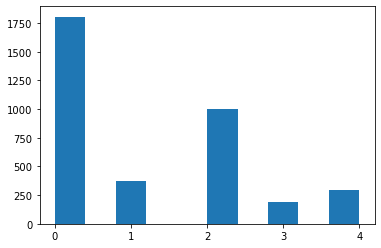

In [8]:
#We see the class balance with a histogram
train_df.diagnosis.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show() 

In [20]:
#As the classes are not balanced, we calculate penalized weights for the criterion function
from sklearn.utils import class_weight

In [22]:
#So we have to calculate the weights for each class, which can be used to calculate the loss.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df.diagnosis)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
print(class_weights) #Prints the calculated weights for the classes.

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


# 3. Split dataset in train and test

In [37]:
class dataset(Dataset):
    #Constructor
    def __init__(self, df, data_path, image_transform=None, train=True):
        super(Dataset,self).__init__()
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
    #Returns the number of samples in the dataset
    def __len__(self):
        return len(self.df)
    #Images are loaded
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png')
        if self.image_transform:
            image = self.image_transform(image)
        if self.train:
            label = self.df['diagnosis'][index]
            return image,label
        else:
            return image

In [57]:
# We transform the image
image_transform = transforms.Compose([transforms.Resize([224,224]),
                                      transforms.ToTensor()
                                     ])

In [58]:
#Load dataset
data_set = dataset(train_df, f'{path}train', image_transform=image_transform)

In [59]:
#We splot dataset in train (80%) and test (20%)
train_set, valid_set = torch.utils.data.random_split(data_set,[0.8,0.2])
print(len(train_set))
print(len(valid_set))

2930
732


In [60]:
#We generate a dataloaders for train and test
train_dataloader = DataLoader(train_set,
                              batch_size=32,
                              shuffle=True)
valid_dataloader = DataLoader(valid_set,
                              batch_size=32,
                              shuffle=True)

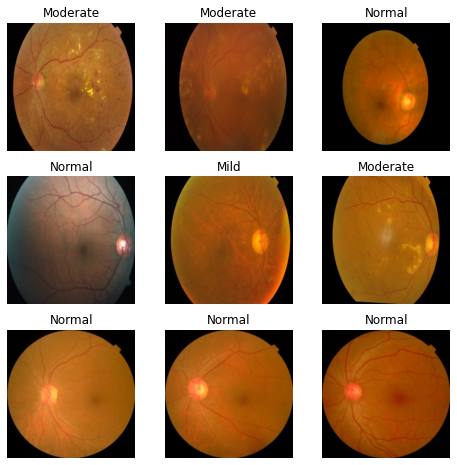

In [61]:
labels_map = {
    0: "Normal",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataloader), size=(1,)).item()
    img, label = train_dataloader.dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0))
plt.show()

# 4. Create the model

In [62]:
import torch.nn as nn

In [63]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [64]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [65]:
num_classes = len(class_weights)

In [66]:
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes).to(device)

In [67]:
#We see the summary of our convolutional neural network
from torchsummary import summary

In [68]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
    ResidualBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [69]:
#We see architecture of convolutional neural network
from torchview import draw_graph

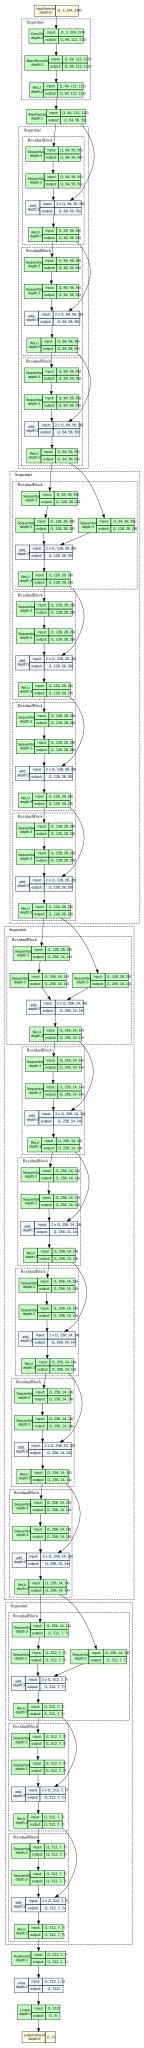

In [71]:
model_graph = draw_graph(model=model, input_size=(1,3,224,224), expand_nested=True)
model_graph.resize_graph(scale=2.0)
model_graph.visual_graph

In [72]:
# No. of epochs and learning rate
num_epochs = 10
learning_rate = 0.001
# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 6. Train the model

In [74]:
import gc

In [ ]:
print('Please a moment we are making magic now!!!...')
loss_ = []
accuracy_train = []
accuracy_test = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss.item()))
    loss_.append(loss.item())
    
    # Training
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        print('Accuracy of the network on the {} training images: {} %'.format(len(train_set), 100 * correct / total)) 
        accuracy_train.append(100 * correct / total)
        
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        print('Accuracy of the network on the {} validation images: {} %'.format(len(valid_set), 100 * correct / total))
        accuracy_test.append(100 * correct / total)

Please a moment we are making magic now!!!...
Epoch [1/10], Loss: 1.2779
Accuracy of the network on the 2930 training images: 44.91467576791809 %
Accuracy of the network on the 732 validation images: 45.21857923497268 %
Epoch [2/10], Loss: 1.2901
Accuracy of the network on the 2930 training images: 61.774744027303754 %
Accuracy of the network on the 732 validation images: 59.42622950819672 %
Epoch [3/10], Loss: 1.6885
Accuracy of the network on the 2930 training images: 58.25938566552901 %
Accuracy of the network on the 732 validation images: 56.967213114754095 %
Epoch [4/10], Loss: 1.1255
Accuracy of the network on the 2930 training images: 51.94539249146758 %
Accuracy of the network on the 732 validation images: 51.22950819672131 %
Epoch [5/10], Loss: 0.9435
Accuracy of the network on the 2930 training images: 61.33105802047782 %
Accuracy of the network on the 732 validation images: 58.333333333333336 %


# 7. Define a function to plot the training and testing data

In [ ]:
def plot_loss(x1, y1):
    plt.plot(x1, y1)
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.show()

In [ ]:
epochs_p = [i for i in range(num_epochs)]
plot_loss(epochs_p, loss_)

In [ ]:
def plot_acc(x1, y1, x2, y2):
    plt.plot(x1,y1)
    plt.plot(x2,y2)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
plot_acc(epochs_p, accuracy_train, epochs_p, accuracy_test)

# 8. Make predictions on test set, create a Classification Report

In [ ]:
from torchmetrics.classification import F1Score, Accuracy, ConfusionMatrix, Recall, Specificity

In [ ]:
ytrueBatch = []
ypredBatch = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        ytrueBatch.append(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        ypredBatch.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
    print('Accuracy of the network on the {} test images: {} %'.format(len(valid_set), 100 * correct / total))   

In [ ]:
ytrue = torch.ones(len(valid_set))
ypred = torch.ones(len(valid_set))

In [ ]:
cont = 0
for i in range(len(valid_dataloader)):
    for j in range(len(ytrueBatch[i])):
        ytrue[cont] = ytrueBatch[i][j]
        ypred[cont] = ypredBatch[i][j]
        cont+=1

In [ ]:
AccuracyM = Accuracy(task='multiclass', num_classes=4)
print(AccuracyM(ytrue, ypred))
RecallM = Recall(task='multiclass', num_classes=4)
print(RecallM(ytrue, ypred))
SpecificityM = Specificity(task='multiclass', num_classes=4)
print(SpecificityM(ytrue, ypred))
F1ScoreM = F1Score(task='multiclass', num_classes=4)
print(F1ScoreM(ytrue, ypred))
ConfusionMatrixM = ConfusionMatrix(task='multiclass', num_classes=4)
print(ConfusionMatrixM(ytrue, ypred))

In [ ]:
confusionmatrix = ConfusionMatrixM(ytrue, ypred).numpy()
confusionmatrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
classes = ('0' '1' '2' '3', '4')
disp = ConfusionMatrixDisplay(confusion_matrix=confusionmatrix, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()